In [1]:
!date

Mon May 30 12:55:58 PDT 2022


# Microglia
## - comparison between control and experiment datasets
Unfiltered data obtained from using kb with multimapping function. Ref genome includes WRE.

___

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [17]:
import sys
import anndata
# import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Custom violinplot code
from plotting_funcs import violinplot

import pandas as pd

import gget

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [4]:
# set random seed
np.random.seed(926)

In [5]:
def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Load AnnData object

In [6]:
adata = anndata.read_h5ad("../../finchseq_data/all_celltype.h5ad")
adata

AnnData object with n_obs × n_vars = 35804 × 22151
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', 'leiden', 'celltype', 'connectivity'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Define masks to separate control and experiment datasets:

In [7]:
control_mask = np.logical_or(adata.obs["batch"]=="control1", adata.obs["batch"]=="control2")
experiment_mask = np.logical_or(adata.obs["batch"]=="experiment1", adata.obs["batch"]=="experiment2")

Add new obs column to separate between control and experiment in general, without separating between batches:

In [8]:
adata.obs["batch_g"] = ""

adata.obs.loc[control_mask, "batch_g"] = "control"
adata.obs.loc[experiment_mask, "batch_g"] = "experiment"

adata.obs

,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g
barcode,,,,,,,,,
AAACCCAAGCACTGGA-0,zebrafinch,control1,483.000000,0,483.000000,13,mural cells 2,0,control
AAACCCAAGCGTCAAG-0,zebrafinch,control1,946.000061,0,946.000061,3,microglia 1,1,control
AAACCCAAGGTCACAG-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control
AAACCCAAGTCATTGC-0,zebrafinch,control1,1407.000000,0,1407.000000,10,astrocytes 2,3,control
AAACCCAAGTGCTACT-0,zebrafinch,control1,1060.000000,0,1060.000000,1,GABAergic neurons 1,2,control
...,...,...,...,...,...,...,...,...,...
TTTGTTGTCAACTCTT-3,zebrafinch,experiment2,791.999939,3,791.999939,0,glutamatergic neurons 1,undefined 1,experiment
TTTGTTGTCGATCCAA-3,zebrafinch,experiment2,4345.000000,3,4345.000000,2,migrating neuroblasts,9,experiment
TTTGTTGTCTAGATCG-3,zebrafinch,experiment2,1352.000000,3,1352.000000,6,mural / vascular endothelial cells 1,6,experiment


Split experiment and control data into separate AnnData objects for plotting:

In [9]:
adata_exp = adata[adata.obs.batch_g=="experiment"]
adata_ctrl = adata[adata.obs.batch_g=="control"]

___

# Microglia activation

Activated microglia produce free oxygen radicals and nitric oxide. They also express NMDA receptor agonists, and various proteases and cytokines.  
References:  
https://www.sciencedirect.com/science/article/pii/S1347861315001772?via%3Dihub  
https://www.sciencedirect.com/science/article/pii/S0165017307000550?via%3Dihub  

In [10]:
act_micro_markers = [
    ## Neurotoxic markers
    # Free oxygen radicals production
    "NOX1_ENSTGUG00000021927.1",      # NADPH oxidase (NOX) is a multicomponent enzyme complex that, upon activation, produces the highly reactive free radical superoxide
    "NOX3_ENSTGUG00000011124.2",
    "NOX4_ENSTGUG00000012893.2",
    # Nitric oxide production
    "NOS1_ENSTGUG00000010372.2",      # Nitric Oxide Synthase 1
    "NOS2_ENSTGUG00000008604.2",
    "NOS3_ENSTGUG00000019554.1",
    "_ENSTGUG00000027710.1",          # Nitric Oxide Synthase 1 Adaptor Protein    
    # Pro-inflammatory genes found in DE gene analysis
    "_ENSTGUG00000010325.2",
    "IFI6_ENSTGUG00000021692.1",  
    # Possible NMDAR agonsits found in DE gene analysis
    "SRGN_ENSTGUG00000003885.2",      # Serglycin; Might activate NMDARs https://jneuroinflammation.biomedcentral.com/articles/10.1186/s12974-019-1504-6
    
    ## Neuroprotective markers
    "TGFBI_ENSTGUG00000001216.2",
    "TGFBRAP1_ENSTGUG00000009752.2",
    "TGFBR1_ENSTGUG00000006726.2",   # Who receives the TGFB1 signal?
    
    ## Rescue signal canidate CX3C and its receptor
    "_ENSTGUG00000024320.1",         # C-X3-C motif chemokine ligand 1
    "CX3CR1_ENSTGUG00000018365.2",   # C-X3-C motif chemokine receptor 1
    
    # From Masuda et al JPS 2015
    "IRF1_ENSTGUG00000001375.2",
    "IRF8_ENSTGUG00000004127.2",
    "TLR2_ENSTGUG00000005181.2",
    "IL1B_ENSTGUG00000003368.2"
]
    
act_micro_names = [
    ## Neurotoxic markers
    # Free oxygen radicals production
    "NOX1",
    "NOX3",
    "NOX4",
    # Nitric oxide production
    "NOS1",
    "NOS2",
    "NOS3",
    "NOS1AP",
    # Pro-inflammatory genes found in DE gene analysis
    "CCL3L3",
    "IFI6",
    # Possible NMDAR agonsits found in DE gene analysis    
    "SRGN",
    
    ## Neuroprotective markers
    "TGFBI",
    "TGFBRAP1",
    "TGFBR1",
    
    ## Rescue signal canidate CX3C and its receptor
    "CX3C",
    "CX3CR1",
    
    # From Masuda et al JPS 2015
    "IRF1",
    "IRF8",
    "TLR2",
    "IL1B"
]

In [11]:
# adata_mglia = adata[np.char.startswith(nd(adata.obs.celltype.values).astype(str), "microglia")]
# adata_mglia

In [12]:
# adata.var[adata.var.index.str.contains("CTSS")]

Individual cluster analysis (obs column: celltype).


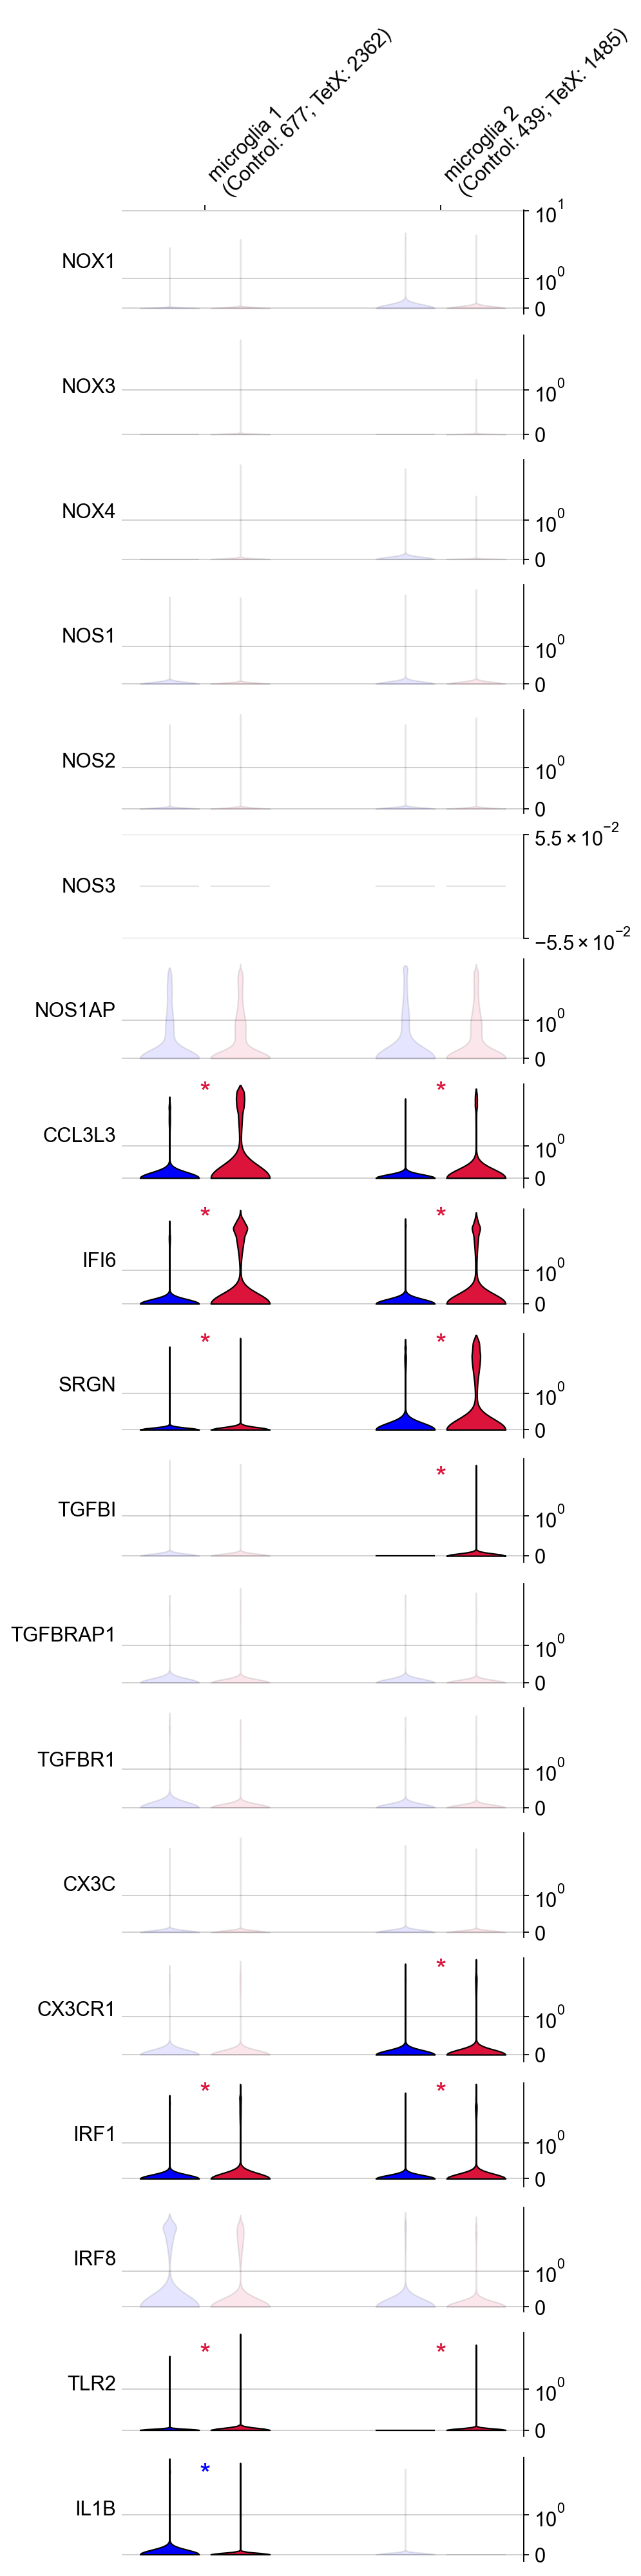

In [16]:
genes = act_micro_markers
labels = act_micro_names
celltypes = ["microglia 1", "microglia 2"]

violinplot(
    adata_exp,
    adata_ctrl,
    genes,
    labels,
    celltypes,
    "microglia_activation_genes",
    fold_change_min=1.5,
    figsize=(5, 30),
)

___